**Importamos librerías**

In [1]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

**Usamos una función para graficar**

In [3]:
# Funciones auxiliares

def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()


**Instalamos yfinance**

In [4]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.0 MB/s 
     |████████████████████████████████| 6.4 MB 22.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


**Cargamos los Datos**

In [5]:
import yfinance as yf

brk = yf.Ticker('PEN=X') 

dataset = brk.history(period="max", auto_adjust=True)

dataset

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2001-05-31,3.623000,3.623000,3.623000,3.623000,0,0,0
2001-06-01,3.623000,3.623000,3.623000,3.623000,0,0,0
2001-06-04,3.623000,3.623000,3.623000,3.623000,0,0,0
2001-06-05,3.623000,3.623000,3.623000,3.623000,0,0,0
2001-06-06,3.623000,3.623000,3.623000,3.623000,0,0,0
...,...,...,...,...,...,...,...
2022-07-15,3.876485,3.874454,3.827235,3.876485,0,0,0
2022-07-18,3.819752,3.825525,3.813185,3.819752,0,0,0
2022-07-19,3.825525,3.836080,3.827716,3.825525,0,0,0


**Dividimos los datos en train y test**

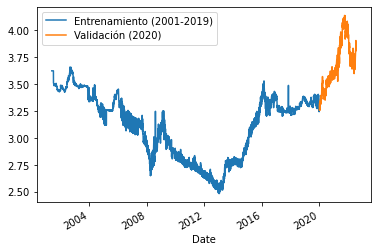

In [6]:
# Sets de entrenamiento y validación (test) 
# La LSTM se entrenará con datos de 2019 hacia atrás. La validación se hará con datos de 2020 en adelante.
# En ambos casos sólo se usará el valor más Alto de la acción para cada día
#
set_entrenamiento = dataset[:'2019'].iloc[:,1:2]
set_validacion = dataset['2020':].iloc[:,1:2]

set_entrenamiento['High'].plot(legend=True)
set_validacion['High'].plot(legend=True)
plt.legend(['Entrenamiento (2001-2019)', 'Validación (2020)'])
plt.show()

**Normalización del set de entrenamiento**

In [7]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

In [8]:
# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida un dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

**Red LSTM**

In [9]:
# Red LSTM

dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.fit(X_train,Y_train,epochs=20,batch_size=32)

Epoch 1/20
150/150 [==============================] - 7s 27ms/step - loss: 0.0055
Epoch 2/20
150/150 [==============================] - 4s 29ms/step - loss: 0.0014
Epoch 3/20
150/150 [==============================] - 4s 27ms/step - loss: 0.0012
Epoch 4/20
150/150 [==============================] - 4s 28ms/step - loss: 0.0010
Epoch 5/20
150/150 [==============================] - 4s 30ms/step - loss: 9.9052e-04
Epoch 6/20
150/150 [==============================] - 5s 30ms/step - loss: 9.6096e-04
Epoch 7/20
150/150 [==============================] - 4s 29ms/step - loss: 9.3757e-04
Epoch 8/20
150/150 [==============================] - 4s 28ms/step - loss: 9.2830e-04
Epoch 9/20
150/150 [==============================] - 4s 27ms/step - loss: 9.0069e-04
Epoch 10/20
150/150 [==============================] - 4s 27ms/step - loss: 8.9702e-04
Epoch 11/20
150/150 [==============================] - 5s 31ms/step - loss: 8.7245e-04
Epoch 12/20
150/150 [==============================] - 4s 29ms/step 

In [10]:
# Validación (predicción del valor de las acciones)
#
x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


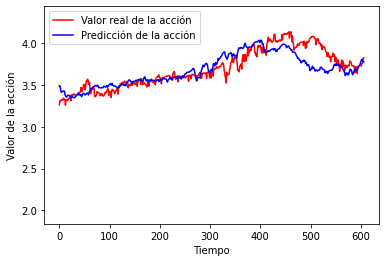

In [11]:
# Graficar resultados
graficar_predicciones(set_validacion.values,prediccion)